# Baseline Model for Banking Lead Conversion Prediction

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, confusion_matrix, fbeta_score

/Users/sukhumarn/anaconda3/envs/mar_rl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read Data

In [3]:
data_path = '../data/Banking | Marketing | Leads Conversion Data/train_loan/train.csv'
df = pd.read_csv(data_path)
print('total data size is', df.shape[0])

total data size is 69713


## Feature Extraction

In [4]:
df['DOB'] = df['DOB'].apply(pd.to_datetime)
df['Lead_Creation_Date'] = df['Lead_Creation_Date'].apply(pd.to_datetime)
df['Age'] = (df['Lead_Creation_Date'] - df['DOB'])/ np.timedelta64(1, 'Y')
df['Age'] = np.where(df['Age'] < 0, np.nan, df['Age'])
df['Apply'] = np.where(df['Loan_Amount']>0, 1, 0)
df['Apply'].mean()

0.6025275056302268

In [5]:
label_col = 'Apply'
index_col = 'ID'
date_col = 'Lead_Creation_Date'
feat_cols = ['Gender', 'Age', 'City_Category', 'Employer_Category1', 'Employer_Category2', 
             'Monthly_Income', 'Primary_Bank_Type',
             'Source_Category', 'Existing_EMI']

df['lead_month']## Prep Data

In [6]:
df['lead_month'] = df['Lead_Creation_Date'].astype(str)
df['lead_month'] = df['lead_month'].str[:7]
df.groupby('lead_month').size()

lead_month
2016-01     1994
2016-02     3200
2016-03     2003
2016-04     2298
2016-05     2476
2016-06     2220
2016-07    15466
2016-08    15919
2016-09    18446
2016-10     1616
2016-11     1800
2016-12     2275
dtype: int64

In [27]:
test_cond = df['Lead_Creation_Date'] > '2016-09-01'
train_df = df.loc[~test_cond, :]
test_df = df.loc[test_cond, :].copy()
print('train size is', train_df.shape[0])
print('test size is', test_df.shape[0])

train size is 45576
test size is 24137


In [8]:
X_train = train_df[feat_cols]
y_train = train_df[label_col]
X_test = test_df[feat_cols]
y_test = test_df[label_col]
print('train size is', X_train.shape[0])
print('test size is', X_test.shape[0])

train size is 45576
test size is 24137


In [9]:
numer_feats = ['Age', 'Monthly_Income', 'Existing_EMI']
numer_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

cat_feats = ['Gender', 'City_Category', 'Employer_Category1', 'Employer_Category2', 
             'Primary_Bank_Type', 'Source_Category']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# binary_feats = ['Contacted']
# binary_transformer = Pipeline(
#     steps=[("imputer", SimpleImputer(strategy="constant", fill_value='No')), ("ordinal", OrdinalEncoder())]
# )

transformer = ColumnTransformer(
    transformers=[
        ("num", numer_transformer, numer_feats),
        # ("ordinal", binary_transformer, binary_feats),
        ("cat", cat_transformer, cat_feats)
    ], sparse_threshold = 0
)

In [10]:
transformer.fit(X_train);

In [11]:
X_train_t = transformer.transform(X_train)
X_test_t = transformer.transform(X_test)

In [12]:
transformers = transformer.get_params()['transformers']
feature_names = []
for name, _, features in transformers:
    try:
        Var = transformer.named_transformers_[name].get_feature_names().tolist()
    except AttributeError:
        Var = features
    feature_names = feature_names + Var

/Users/sukhumarn/anaconda3/envs/mar_rl/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Model Training

### Parameter Tuning

In [14]:
def objective(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2']),
        'min_samples_split': trial.suggest_uniform('min_samples_split', 1e-5, 0.5),
        'min_samples_leaf': trial.suggest_uniform('min_samples_leaf', 1e-5, 0.5),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
    }
    clf = RandomForestClassifier(**params, random_state=0)
    score = cross_validate(clf, X, y, cv = 3, scoring = 'roc_auc', return_train_score=True)
    train_score = np.mean(score['train_score'])
    test_score = np.mean(score['test_score'])
    return -(test_score - 0.25 * abs(train_score - test_score))
    

In [15]:
#optuna.delete_study(study_name='banking-lead', storage='sqlite:///../cc-tuning.db')

In [13]:
obj_func = lambda trial: objective(trial, X_train_t, y_train)
train = False
if train:
    study = optuna.create_study(study_name='banking-lead', storage='sqlite:///cc-tuning.db', load_if_exists=True)
    study.optimize(obj_func, n_trials=50)
else:
    study = optuna.load_study(study_name='banking-lead', storage='sqlite:///cc-tuning.db')

## Model Evaluation

In [14]:
pipeline = Pipeline([('transformer', transformer), ('rf', RandomForestClassifier(**study.best_params))])

In [15]:
# clf = RandomForestClassifier(**study.best_params)
# clf.fit(X_train_t, y_train)
pipeline.fit(train_df[feat_cols], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Monthly_Income',
                                                   'Existing_EMI']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'City_Category',
                                                   'Employer_Category1',
                                                   'Employer_Category2',
                                                   'Primary_Bank_Type',
                                                   'Source_Category'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features='log2',
                                        min_samples_leaf=2.6576714888898456e-05,
                                        min_samples_split=0.00031176148168907125,
                                        n_estimators=332))])

In [16]:
# y_train_score = clf.predict_proba(X_train_t)
# y_test_score = clf.predict_proba(X_test_t)
y_train_score = pipeline.predict_proba(train_df[feat_cols])
y_test_score = pipeline.predict_proba(test_df[feat_cols])
y_train_pred = np.where(y_train_score[:, 1] > 0.5, 1, 0)
y_test_pred = np.where(y_test_score[:, 1] > 0.5, 1, 0)

In [17]:
print("train classification report")
print(classification_report(y_train, y_train_pred))
print("test classification report")
print(classification_report(y_test, y_test_pred))

train classification report
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     17561
           1       1.00      0.90      0.95     28015

    accuracy                           0.94     45576
   macro avg       0.93      0.95      0.94     45576
weighted avg       0.95      0.94      0.94     45576

test classification report
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     10148
           1       0.99      0.87      0.93     13989

    accuracy                           0.92     24137
   macro avg       0.92      0.93      0.92     24137
weighted avg       0.93      0.92      0.92     24137



### ROCAUC

In [18]:
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_score[:, 1])
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_score[:, 1])

train_auc = roc_auc_score(y_train, y_train_score[:, 1])
test_auc = roc_auc_score(y_test, y_test_score[:, 1])

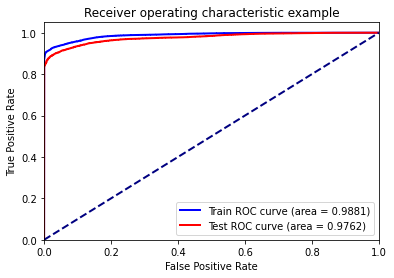

In [19]:
plt.figure()
lw = 2
plt.plot(train_fpr, train_tpr, color="b",lw=lw, label="Train ROC curve (area = %0.4f)" % train_auc)
plt.plot(test_fpr, test_tpr, color="r",lw=lw, label="Test ROC curve (area = %0.4f)" % test_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [20]:
def threshold_analysis(result, label_col, proba_col, tops=None):
    if tops is None:
        tops = [1]
        tops.extend(np.arange(2, 6, 1))
        tops.extend(np.arange(10, 105, 5))
        tops = [t/100 for t in tops]

    threshold_opt = pd.DataFrame()

    for top in tops:
        percentile = 1-top
        threshold = result[proba_col].astype(float).quantile(percentile)

        tn, fp, fn, tp = confusion_matrix(result[label_col], result[proba_col] > threshold).ravel()

        precision = tp/(tp+fp)
        recall = tp/(tp+fn)

        f1 = fbeta_score(result[label_col], result[proba_col] > threshold, beta=1)
        f2 = fbeta_score(result[label_col], result[proba_col] > threshold, beta=2)

        top_idx = top*100
        threshold_opt.loc[top_idx, 'threshold'] = threshold
        threshold_opt.loc[top_idx, 'lead_size'] = (result[proba_col] > threshold).sum()
        threshold_opt.loc[top_idx, 'true_positive'] = tp
        threshold_opt.loc[top_idx, 'false_positive'] = fp
        threshold_opt.loc[top_idx, 'true_negative'] = tn
        threshold_opt.loc[top_idx, 'false_negative'] = fn
        threshold_opt.loc[top_idx, 'precision'] = precision
        threshold_opt.loc[top_idx, 'recall'] = recall
        threshold_opt.loc[top_idx, 'f1'] = f1
        threshold_opt.loc[top_idx, 'f2'] = f2

        threshold_opt.index.name = 'top'

        cols = ['lead_size', 'true_positive', 'false_positive', 'true_negative', 'false_negative']
        threshold_opt[cols] = threshold_opt[cols].astype(int)
    threshold_opt.reset_index(inplace=True)

    return threshold_opt

In [21]:
eval_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_test_score[:, 1]})
threshold_analysis(eval_df, 'y_true', 'y_pred', tops=None)

,top,threshold,lead_size,true_positive,false_positive,true_negative,false_negative,precision,recall,f1,f2
0,1.0,0.997469,241,241,0,10148,13748,1.000000,0.017228,0.033872,0.021442
1,2.0,0.996596,483,483,0,10148,13506,1.000000,0.034527,0.066750,0.042790
2,3.0,0.994297,725,725,0,10148,13264,1.000000,0.051826,0.098546,0.063954
3,4.0,0.991832,966,966,0,10148,13023,1.000000,0.069054,0.129188,0.084853
4,5.0,0.990671,1207,1207,0,10148,12782,1.000000,0.086282,0.158858,0.105575
5,10.0,0.988207,2410,2410,0,10148,11579,1.000000,0.172278,0.293920,0.206456
6,15.0,0.986599,3621,3621,0,10148,10368,1.000000,0.258846,0.411244,0.303892
7,20.0,0.984684,4828,4828,0,10148,9161,1.000000,0.345128,0.513153,0.397144
8,25.0,0.983061,6034,6034,0,10148,7955,1.000000,0.431339,0.602707,0.486691
9,30.0,0.980832,7241,7241,0,10148,6748,1.000000,0.517621,0.682148,0.572891


In [28]:
threshold = 0.966562
test_df['predict_prob'] = y_test_score[:,1]
test_df['predict'] = np.where(y_test_score[:, 1] >= threshold, 1, 0)

In [29]:
test_df.groupby('predict').agg({
    'ID': 'count',
    'Apply': 'sum',
    'Loan_Amount': 'sum'
})

,ID,Apply,Loan_Amount
predict,,,
0,13275,3127,110720000.0
1,10862,10862,446246000.0


In [44]:
sorted_test_df = test_df.sort_values(by=['predict_prob'], ascending=False)
sorted_test_df['cumsum_loan_amount'] = sorted_test_df['Loan_Amount'].cumsum()
sorted_test_df.reset_index(inplace=True)
sorted_test_df.loc[3000, ['predict_prob', 'Loan_Amount', 'cumsum_loan_amount']].head(30)

predict_prob             0.987453
Loan_Amount               35000.0
cumsum_loan_amount    138757000.0
Name: 3000, dtype: object

## Verify Data

In [ ]:
from deepchecks.checks import WholeDatasetDrift
from deepchecks import Dataset
from deepchecks.tabular.suites import full_suite

In [26]:
train_df[cat_feats] = train_df[cat_feats].astype(str)
test_df[cat_feats] = test_df[cat_feats].astype(str)

In [27]:
Dataset

deepchecks.tabular.dataset.Dataset

In [28]:
train_ds = Dataset(train_df[feat_cols+[label_col, date_col]], label=label_col, cat_features=cat_feats, datetime_name=date_col)
test_ds = Dataset(test_df[feat_cols+[label_col, date_col]], label=label_col, cat_features=cat_feats, datetime_name=date_col)

In [ ]:
suite = full_suite()
suite_result = suite.run(train_dataset=train_ds, test_dataset=test_ds, model=pipeline)

In [30]:
suite_result.save_as_html('banking_lead_sult_result.html')

'banking_lead_sult_result.html'